In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import speclite.filters

In [3]:
import astropy.units as u

In [4]:
c = 3e18 # A / s
h = 6.626e-27 # erg s
k_B = 1.381e-16 # erg / K

In [5]:
def blackbody(lam, T):
    # From R&L 1.52 (extra factor of 4 * np.pi comes from integrating over solid angle)
    num = (8 * np.pi * h * c ** 2) / lam ** 5 
    den = np.exp(h * c / (lam * k_B * T)) - 1
    return(num / den) * 1e16 # multiply by (1e8) ** 2 if converting from A^-2 to cm^-2

# blackbody returns units of erg/s/cm2/A

def redshift(lam, sed, z):
    a = 1 / (1 + z)
    return(lam / a, sed * a)

def apply_break(lam, sed, wlen0=4000, ratio=1.5):
    below_break = lam <= wlen0
    break_sed = np.copy(sed)
    break_sed[below_break] /= ratio
    return(break_sed)

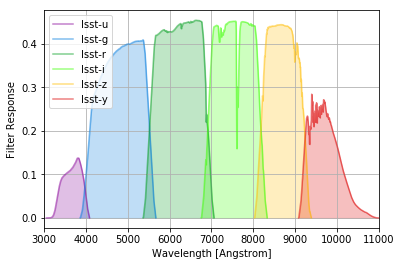

In [6]:
# LSST filters
lsst = speclite.filters.load_filters('lsst2016-*')
speclite.filters.plot_filters(lsst, wavelength_limits=(3000, 11000), legend_loc='upper left')

Load just the r,i,z filters that we need (to avoid issues with the wavelength coverage of other filters):

In [198]:
lsstGRIZ = speclite.filters.load_filters('lsst2016-g', 'lsst2016-r', 'lsst2016-i', 'lsst2016-z')

#### Blackbody spectrum

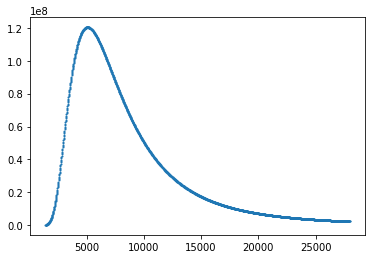

In [7]:
T = 8000
lam = np.arange(1000, 20000, 10.)
sed = blackbody(lam, T)

# z = 0.4
wlen, flux = redshift(lam, sed, 0.4)

plt.scatter(wlen, flux, s=1)
plt.show()

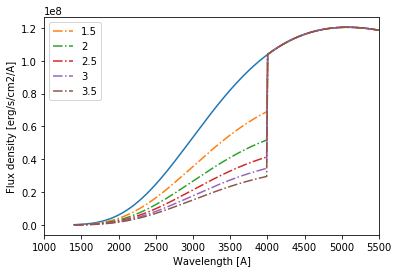

In [8]:
plt.plot(wlen, flux, '-')
for i , d4000 in enumerate([1.5, 2, 2.5, 3, 3.5]):
    plt.plot(wlen, apply_break(wlen, flux, 4000, d4000), '-.', label='{}'.format(d4000))
plt.xlim(1000,5500)
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux density [erg/s/cm2/A]')
plt.legend(loc=2)
plt.show()

In [ ]:
def calculate_mags(z, T, filters, step=0.1):
    
    z = np.asarray(z)
    T = np.asarray(T)
    
    nz = len(z)
    nt = len(T)
    
    mags = np.empty((nt, nz, len(filters)))
    
    # Calculate rest-frame wavelength range that will always cover
    # the filters after applying a redshift.
    z_min, z_max = np.percentile(z, (0, 100))
    filt_min = np.min([f.wavelength[0] for f in filters])
    filt_max = np.max([f.wavelength[-1] for f in filters])
    wlen_min = 0.9 * filt_min / (1 + z_max)
    wlen_max = 1.1 * filt_max / (1 + z_min)

    lam_rest = np.arange(wlen_min, wlen_max, step)
    
    for i, tt in enumerate(T):
        
        sed_rest = blackbody(lam=lam_rest, T=tt)
        
        for j, zz in enumerate(z):
            
            lam, sed = redshift(lam=lam_rest, sed=sed_rest, z=zz)

            magnitudes = filters.get_ab_magnitudes(sed, lam)
            for k, name in enumerate(filters.names):
                mags[i, j, k] = magnitudes[name][0]
    
    return mags

In [9]:
redshifts = np.arange(0, 3.6, 0.2)
temperatures = [4000, 5000, 6000, 7000, 8000, 9000, 10000]

mags = calculate_mags(redshifts, temperatures, lsst)

colors = mags[:, :, :-1] - mags[:, :, 1:]

Plotting 8000K


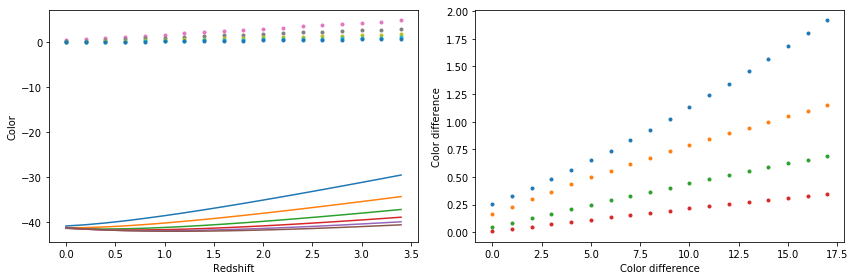

In [10]:
def plot(it=4, z=redshifts):
    print('Plotting {}K'.format(temperatures[it]))
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    nmag = mags.shape[-1]
    for band in range(nmag):
        ax[0].plot(z, mags[it, :, band])
    for col in range(nmag - 1):
        ax[0].plot(z, colors[it, :, col], '.')
    ax[0].set_xlabel('Redshift')
    ax[0].set_ylabel('Color')
    
    
    for diff in range(nmag - 2):
        ax[1].plot(colors[it, :, diff] - colors[it, :, diff + 1], '.')
    ax[1].set_xlabel('Color difference')
    ax[1].set_ylabel('Color difference')
    
    
    plt.tight_layout()
    
plot(it=4)

A linear relationship between colors $a(z)-b(z)$ and $b(z)-c(z)$ can be written:
$$
\begin{aligned}
a(z) - b(z) &= A (b(z) - c(z)) + \text{const} \\
\Rightarrow \; b(z) &= \alpha a(z) + (1 - \alpha) c(z) + \text{const}
\end{aligned}
$$
with slope $A$ and $\alpha = 1/(A+1)$ an arbitrary constant. In other words, the linear relationship tells us that the intermediate magnitude $b(z)$ can be calculated using the same linear combination of the outer magnitudes $a(z)$ and $c(z)$ over the range of redshifts considered.  Therefore we should expect this for a sufficiently smooth SED where $b(z)$ contains very little additional information beyond $a(z)$ and $c(z)$.

#### Color vs Color

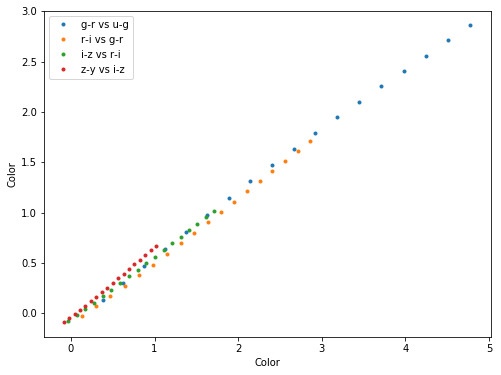

In [11]:
it = 4

labels = ['u', 'g', 'r', 'i', 'z', 'y']

plt.figure(figsize=(8,6))
for diff in range(mags.shape[-1] - 2):
    plt.plot(colors[4, :, diff], colors[4, :, diff + 1], '.', 
             label = labels[diff + 1] + '-' + labels[diff + 2] + ' vs ' + labels[diff] + '-' + labels[diff + 1] )
plt.xlabel('Color')
plt.ylabel('Color')
plt.legend()
plt.show()

Is this showing how redshifting significantly affects the color-color distribution for the same source through different filters? Why are points closer together in the redder filters?

Perhaps due to fact that relative difference between points on SEDs gets smaller as you go further up in redshift? 

Let's see. Plot SED at different redshifts:

In [12]:
filters = lsst
z = redshifts

z = np.asarray(z)
nz = len(z)

step = 0.1

# Calculate rest-frame wavelength range that will always cover
# the filters after applying a redshift.
z_min, z_max = np.percentile(z, (0, 100))
filt_min = np.min([f.wavelength[0] for f in filters])
filt_max = np.max([f.wavelength[-1] for f in filters])
wlen_min = 0.9 * filt_min / (1 + z_max)
wlen_max = 1.1 * filt_max / (1 + z_min)
    
lam_rest = np.arange(wlen_min, wlen_max, step)
sed_rest = blackbody(lam=lam_rest, T=8000) * 1e16

lam = np.empty((nz, len(lam_rest)))
sed = np.empty((nz, len(sed_rest)))

for j, zz in enumerate(z):
    
    lam[j], sed[j] = redshift(lam=lam_rest, sed=sed_rest, z=zz)

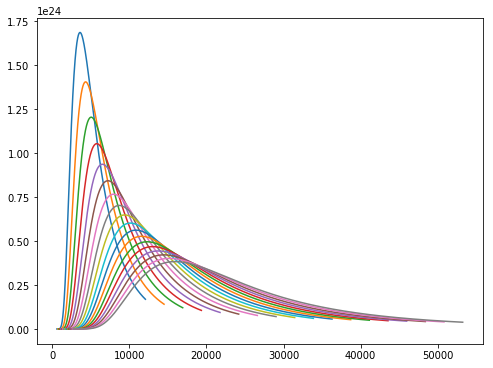

In [13]:
plt.figure(figsize=(8,6))
for i in range(nz):
    plt.plot(lam[i], sed[i])
plt.show()

#### What is the AB zeropoint for each filter?

In [14]:
u_band = speclite.filters.load_filter('lsst-u')
g_band = speclite.filters.load_filter('lsst-g')
r_band = speclite.filters.load_filter('lsst-r')
i_band = speclite.filters.load_filter('lsst-i')
z_band = speclite.filters.load_filter('lsst-z')
y_band = speclite.filters.load_filter('lsst-y')

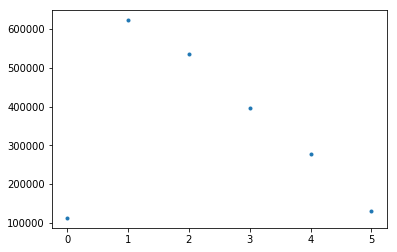

In [15]:
plt.plot([u_band.ab_zeropoint.value, g_band.ab_zeropoint.value, r_band.ab_zeropoint.value, i_band.ab_zeropoint.value, 
         z_band.ab_zeropoint.value, y_band.ab_zeropoint.value], '.')
plt.show()

##### Aside: just plotting linear relation in David's note above

Let's look at the first two colors:
$$
\begin{aligned}
a(z) - b(z) &= u - g\\
b(z) - c(z) &= g -r
\end{aligned}
$$

We can fit a line in color space:

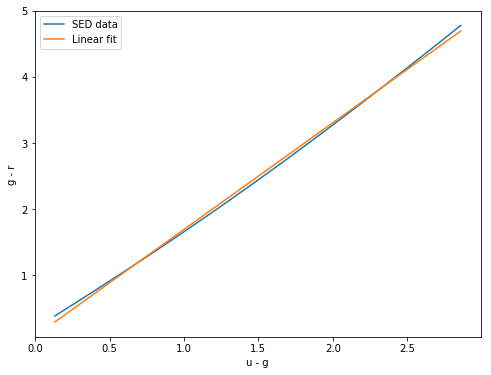

In [142]:
y = colors[4, :, 0]
x = colors[4, :, 1]

# Linear fit
linear = np.polyfit(x, y, deg=1)

plt.figure(figsize=(8,6))
plt.plot(x, y, label='SED data')
plt.plot(x, np.polyval(linear, x), label='Linear fit')
plt.xlabel('u - g')
plt.ylabel('g - r')
plt.legend()
plt.show()

Or equivalently, use the derivation above to plot in redshift space using coefficients from linear fit:

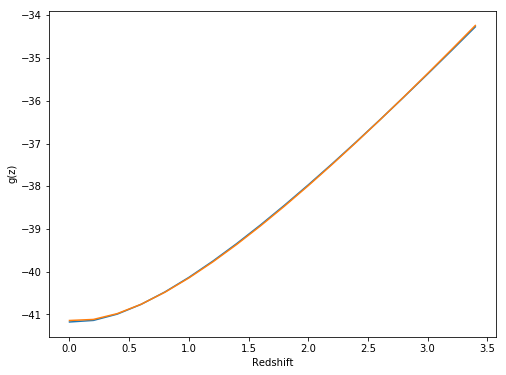

In [212]:
A, const = linear
alpha = 1 / (1+A)

u = mags[it, :, 0]
g = mags[it, :, 1]
r = mags[it, :, 2]

plt.figure(figsize=(8,6))
plt.plot(redshifts, g)
plt.plot(redshifts, alpha * u + (1 - alpha) * r - alpha * const)
plt.xlabel('Redshift')
plt.ylabel('g(z)')
plt.show()